In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container {width: 100% !important}</style>'))

C:\Users\samha\AppData\Local\Temp\ipykernel_14960\3593773758.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


When we run the current script, it takes some minutes to run the VWatt Script. The expected time should be less than 2 seconds since the program is only calculating curtailed generation in a day.

The reason behind this:

The original VWatt Script from Tim is written in a monthly basis
Tim's original script uses pd.read_csv for the data many times! (eg outside of the first and second run, in the first run, and in the second run), which is mainly the problem
So, possible solutions might be:

Modify the script into daily basis
Modify the script so that the pd.read_csv for the data is only deployed once.

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import pytz #for timezone calculation
import math
import matplotlib.dates as md
import gc
import os
from datetime import datetime
%matplotlib qt
%matplotlib inline

# ================== Global parameters for fonts & sizes =================
font_size = 10
rc={'font.size': font_size, 'axes.labelsize': font_size, 'legend.fontsize': font_size, 
    'axes.titlesize': font_size, 'xtick.labelsize': font_size, 'ytick.labelsize': font_size}
plt.rcParams.update(**rc)
plt.rc('font', weight='bold')
 
# For label titles
fontdict={'fontsize': font_size, 'fontweight' : 'bold'}
# can add in above dictionary: 'verticalalignment': 'baseline' 

style = 'ggplot' # choose a style from the above options
plt.style.use(style)

def input_general_files(file_path):
    circuit_details = pd.read_csv(file_path + r"/unsw_20190701_circuit_details.csv")
    site_details = pd.read_csv (file_path + r"/unsw_20190701_site_details.csv")
    site_details = site_details.merge(circuit_details, left_on = 'site_id', right_on = 'site_id')
    unique_cids = pd.read_csv(file_path + r"/UniqueCids.csv", index_col = 0)
    return site_details, unique_cids

def site_organize(c_id_idx, site_details, data, unique_cids):
    """Get a single site data and relevant meta-data information.

    Args:
        c_id_idx (int): c_id value
        site_details (df): site_details dataframe from unsw_20190701_site_details.csv file
        data (df): D-PV time-series dataframe from input_monthly_file function output
        unique_cids (df): Dataframe listing unique c_id's and their corresponding site_id

    Returns:
        data_site(df): D-PV time-series dataframe, filtered by its site_id and cleaned (polarity correction etc)
        ac_cap (float): inverter capacity in W
        dc_cap (float): PV array capacity in Wp
        eff_system (float): Assumed PV array efficiency between 0 and 1
        inverter (str): Concatenated string of inverter manufacturer and model
        
    Originally written by Baran for VVAr Curtailment Calculation.
    """
    
    #c_id = unique_cids.loc[c_id_idx][0]
    c_id = c_id_idx
    
    polarity = site_details.loc[site_details['c_id'] == c_id, 'polarity'].values[0] # get the polarity of the site
    ac_cap = site_details.loc[site_details['c_id'] == c_id, 'ac_cap_w'].values[0]
    dc_cap = site_details.loc[site_details['c_id'] == c_id, 'dc_cap_w'].values[0]
    inverter = site_details.loc[site_details['c_id'] == c_id, 'inverter_manufacturer'].values[0] + ' ' + site_details.loc[site_details['c_id'] == c_id, 'inverter_model'].values[0]

    # Extract single site data and organize: 
    data_site = data[data['c_id'] == c_id].sort_index() # get the monthly data of the specific c_id

    data_site['power'] = data_site['power'].values * polarity # polarity correction for real power
    data_site.loc[data_site['power'] < 0, 'power'] = 0 #replace negative power value into zero
    data_site['reactive_power'] = data_site['reactive_power'].values * polarity # polarity correction for reactive power
    
    data_site['reactive_power'] = [data_site['reactive_power'].values * -1 if np.percentile(data_site.loc[(data_site.index.hour >= 7) & (data_site.index.hour <= 17), 'reactive_power'], 75) < 0 else data_site['reactive_power'].values][0]  # double check the polarity for reactive power
    
    if (abs(np.percentile(data_site['reactive_power'], 99))> ac_cap) | (abs(np.percentile(data_site['reactive_power'], 1))> ac_cap): #some VAr measurements in energy format and needs to be divided by duration (i.e., 60 sec)
        # data_site['reactive_power'] =  data_site['reactive_power'].values / data_site['duration'].values # unfortunately SolA data doesn't calculate energy according to respective duration but uses a fixed 60 sec values for energy calculation
        data_site['reactive_power'] =  data_site['reactive_power'].values / 60
        
    data_site.index = pd.to_datetime([str(d)[0:19] for d in data_site.index]) ## convert index to make the df plottable (by removing the UTC conversion)
    data_site.sort_index(ascending = True, inplace = True) # sort the index in ascending form
    # System efficiency for calculating theoretical max output later on (use conservative loss estimates for DC power)
    eff_inv = 0.98
    eff_vdrop = 0.98 
    eff_derating = 0.99  # module derating losses
    eff_system = eff_inv * eff_vdrop * eff_derating

    # Apparent power of the inverter
    data_site['va'] = np.sqrt (data_site['power'].values**2 + data_site['reactive_power'].values**2)
    data_site['pf'] = data_site['power']/data_site['va']
    
    return data_site, ac_cap, dc_cap, eff_system, inverter

def check_clear_sky_day(date):
    """Check whether a certain date is a clear sky day based on the ghi data of that day. Needs ghi data.

    Args:
    date (str): dat ein YYYYMMDD format

    Returns:
    clear_sky_day (bool): is it a clear sky day or not
    
    Funcitons needed:
    - Get_timestamp_date_string
    - Separate_ghi_data
    - Detect_clear_sky_day

    Originally written by Tim for VWatt Curtailment Calculation.
    """
    dateFile = date[:4]+'_'+ date[5:7]
    ghi = pd.read_csv(file_path +'/sl_023034_' + dateFile + ".txt")
    timestamp_date_string = Get_timestamp_date_string(dateFile)
    separated_ghi_data = Separate_ghi_data(timestamp_date_string, ghi)
    ghi_df = separated_ghi_data[date]
    res, average_delta_y = Detect_clear_sky_day(ghi_df, 530)

    if res:
        #clear_sky_days.append(date)
        #overall_clear_sky_days_dict[dateFile].append(date)
        is_clear_sky_day = True
    else:
        is_clear_sky_day = False
    return is_clear_sky_day

# ADJUST FORMATE FOR TIMESTAMP STRINGS
def Get_timestamp_date_string(string):
    x = string.split("_")
    return x[0] + "-" + x[1]

# LOOK FOR FOR SUDDEN VARIATIONS IN SOLAR INSOLATION DATA WHICH INDICATES LIKELY CLOUD COVER, AS OPPOSED TO CLEAR PARABOLIC SHAPE OF CLEAR SKY DAY GHI CURVES
def Detect_clear_sky_day(ghi_df, min_max_ghi):
    df_daytime = ghi_df.loc[ghi_df['mean_ghi'] > 0]

    collective_change = 0
    ghi_list = df_daytime.mean_ghi.tolist()

    for i in range(len(ghi_list)-1):
        collective_change += abs(ghi_list[i+1] - ghi_list[i])

    if len(df_daytime.index) == 0:
        return False, 0
    
    average_delta_y = collective_change/len(df_daytime.index)

    if average_delta_y < 5 and max(ghi_df.mean_ghi) > min_max_ghi:
        return True, average_delta_y
    else:
        return False, average_delta_y

# SEPARATE THE BoM GHI DATA FILES PER DAY TO SEARCH FOR CLEAR SKY DAYS
def Separate_ghi_data(month, ghi):
    ghi['ts'] = pd.to_datetime(pd.DataFrame({'year': ghi['Year Month Day Hours Minutes in YYYY'].values,
                                                    'month': ghi['MM'],
                                                    'day': ghi['DD'],
                                                    'hour': ghi['HH24'],
                                                    'minute': ghi['MI format in Local standard time']}))
    ghi.rename(columns={'Mean global irradiance (over 1 minute) in W/sq m': 'mean_ghi',
                        'Minimum 1 second global irradiance (over 1 minute) in W/sq m': 'min_ghi',
                        'Maximum 1 second global irradiance (over 1 minute) in W/sq m': 'max_ghi',
                        'Standard deviation of global irradiance (over 1 minute) in W/sq m': 'sd_ghi',
                        'Uncertainty in mean global irradiance (over 1 minute) in W/sq m': 'uncertainty_ghi'},
               inplace=True)
    key_ghi_values = ghi[['ts', 'mean_ghi', 'min_ghi', 'max_ghi', 'sd_ghi', 'uncertainty_ghi']].copy()
    key_ghi_values['mean_ghi'] = key_ghi_values.apply(lambda row: String_to_Float(row['mean_ghi']), axis=1)
    key_ghi_values['min_ghi'] = key_ghi_values.apply(lambda row: String_to_Float(row['min_ghi']), axis=1)
    key_ghi_values['max_ghi'] = key_ghi_values.apply(lambda row: String_to_Float(row['max_ghi']), axis=1)


    combined_ghi_dict = {}
    month_number = int(month.split('-')[1])

    for day in range(1, Days_in_month(month_number) + 1):
        day_string = str(day)
        if day < 10:
            day_string = "0" + day_string

        date = month + "-" + day_string
        df = key_ghi_values.loc[key_ghi_values['ts'] > date + " 00:00:01"]
        df = df.loc[key_ghi_values['ts'] < date + " 23:59:01"]

        combined_ghi_dict[date] = df

    return combined_ghi_dict

# REMOVE SPACES AND CHECK IF VALUE NULL
def String_to_Float(string):
    x = string.strip()
    if not x:
        x = 0
    else:
        x = float(x)
    return x

def Days_in_month(month):
        switcher = {
            1: 31,
            2: 29,
            3: 31,
            4: 30,
            5: 31,
            6: 30,
            7: 31,
            8: 31,
            9: 30,
            10: 31,
            11: 30,
            12: 31,
        }
        return switcher.get(month, 0)
    
def filter_sunrise_sunset(df):
    """Filter a D-PV Time series data based on its estimated sunrise and sunset time.

    Args:
    df (df): D-PV Time series data

    Returns:
    sunrise (timestamp): estimated sunrise time (when power is >10 W for the first time in a day)
    sunset (timestamp): the opened ghi data (when power is >10 W for the last time in a day)
    df (df): filtered D-PV Time series data
    """
    if df is None or len(df.index) == 0:
        return None

    tmpDF = df.loc[df['power'] > 10]
    if len(tmpDF.index) == 0:
        return None

    sunrise = tmpDF.index[0]
    sunset = tmpDF.index[-1]

    df = df.loc[df.index > sunrise]
    df = df.loc[df.index < sunset]

    return sunrise, sunset, df

def filter_power_data(df):
    """Take the time and power data from D-PV time-series data & filter out curtailment. Will be used for polyfit regression.

    Args:
    df (df): Time-series D-PV data with power column and timestamp as an index

    Returns:
    powerArray (pd series): filtered power data
    timeArray (pd datetime): filtered timestamp data
    """
    
    maxDailyPower = max(df.power)
    if len(df.loc[df['power'] == maxDailyPower].index) > 1:
        return None, None
    
    filter_first_half = []
    filter_second_half = []
    powerArray = df.power
    timeArray = df.index
    
    halfFlag = True  # True is first half, False is second half
    last_highest_power = 0
    
    for power in powerArray:

        # IF power IS GREATER THAN last_highest_power THEN INCLUDE power AND INCREASE last_highest_power
        if power > last_highest_power:
            last_highest_power = power
            filter_first_half.append(True)
        else:
            filter_first_half.append(False)

        if power == maxDailyPower:
            break
            
    last_highest_power = 0
    
    # PERFORM SAME FILTER ON SECOND SIDE OF POWER ARRAY
    for power in powerArray.iloc[::-1]:

        if power == maxDailyPower:
            break

        if power > last_highest_power:
            last_highest_power = power
            filter_second_half.append(True)
        else:
            filter_second_half.append(False)
            
    # COMBINE TO FILTERED SIDES
    filter_second_half.reverse()
    filterArray = filter_first_half + filter_second_half
    return powerArray[filterArray], timeArray[filterArray]

def FilterDataLimitedGradients(powerArray, timeArray):
    """Filter the powerArray data so it includes only decreasing gradient (so the shape is parabolic)

    Args:
    powerArray (pd series): non curtailment filtered power data
    timeArray (pd datetime): non curtailment filtered timestamp data

    Returns:
    powerArray (pd series): gradient filtered power data
    timeArray (pd datetime): gradient filtered timestamp data
    
    Written by Tim
    """

    if powerArray is None:
        return None, None

    # IN GENERAL ANLGE MUST BE BETWEEN THESE VALUES
    angleLowerLimit = 80
    angleUpperLimit = 90

    # BUT AFTER 'continuanceLimit' CONTINUOUS VALUES HAVE BEEN ACCEPTED, THE LOWER ANGLE LIMIT IS RELAXED TO THIS VALUE BELOW
    widerAngleLowerLimit = 70
    continuanceLimit = 2

    gradients = []
    timeGradients = []
    powerArray = powerArray.tolist()
    timeArray = timeArray.tolist()
    filterArray = []

    n = len(powerArray)
    gradientsCompliance = [0] * n

    runningCount = 0

    for i in range(1, n):
        g = abs(math.degrees(math.atan((powerArray[i] - powerArray[i - 1]) / (
                    getSingleDateTime(timeArray[i]) - getSingleDateTime(timeArray[i - 1])))))

        addFlag = False

        if g > angleLowerLimit and g < angleUpperLimit:
            addFlag = True
            runningCount += 1

        elif runningCount > continuanceLimit and g > widerAngleLowerLimit:
            addFlag = True

        else:
            runningCount = 0

        if addFlag:
            gradientsCompliance[i - 1] += 1
            gradientsCompliance[i] += 1

        if g > 85:
            gradients.append(g)
            timeGradients.append(timeArray[i])

    if gradientsCompliance[0] == 1 and gradientsCompliance[1] == 2:
        filterArray.append(True)
    else:
        filterArray.append(False)

    for i in range(1, n - 1):
        if gradientsCompliance[i] == 2:
            filterArray.append(True)
        elif gradientsCompliance[i] == 1 and (gradientsCompliance[i - 1] == 2 or gradientsCompliance[i + 1] == 2):
            filterArray.append(True)
        else:
            filterArray.append(False)

    if gradientsCompliance[n - 1] == 1 and gradientsCompliance[n - 2] == 2:
        filterArray.append(True)
    else:
        filterArray.append(False)
    

    powerArray = pd.Series(powerArray)
    timeArray = pd.Series(timeArray)

    powerArray = powerArray[filterArray]
    timeArray = timeArray[filterArray]

    return powerArray, timeArray

def getSingleDateTime(d):
    """CONVERT A SINGLE STRING TIMESTAMP TO DATETIME OBJECTS

    Args:
    d (str): string timestamp

    Returns:
    daetimeobject
    
    Written by Tim
    """
    return md.date2num(datetime.strptime(d, '%Y-%m-%d %H:%M:%S'))

def getDateTimeList(List):
    """CONVERT A LIST STRING TIMESTAMP TO DATETIME OBJECTS, THEN CONVERT IT TO FLOAT OF UNIX TIMESTAMPS.
    
    Args:
    List (pd Series) : List of time in str. Example can be timeArray

    Returns:
    datenums (ndarray) : List of float unix timestamp
    
    This is used for polyfit preparation. Written by Tim
    """
    # 
    dates = [datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in List]
    datenums = md.date2num(dates)
    return datenums

def GetPolyfit(xArray, yArray, functionDegree):
    """GET POLYFIT OF DESIRED DEGREE, NEED xArray as float, not dt object

    Args:
    xArray (ndarray) : List of float unix timestamp
    yArray (pd Series): List of power value corresponding to xArray time
    functionDegree (int): Degree of polynomial. Quadratic functions means functionDegree = 2

    Returns:
    polyfit (np poly1d): polyfit model result, containing list of the coefficients and the constant.
                        The first, second, and third values are coef of x^2, x, and the constant.
    
    Written by Tim
    """
     

    timestamps = xArray
    xp = np.linspace(timestamps[0], timestamps[len(timestamps) - 1], 1000) #IDK what is this for. Seems redudant.
    z = np.polyfit(timestamps, yArray, functionDegree)
    polyfit = np.poly1d(z)

    return polyfit

def check_energy_generated(data_site, date):
    """Get the amount of energy generated in a certain site in a certain day, unit kWh.

    Args:
        data_site (df): Cleaned D-PV time-series data, output of site_orgaize function
        date (str): date in focus

    Returns:
        energy_generated (float): Single value of the total energy generated in that day
    """
    
    #sh_idx = (data_site.index.hour>= 7) & (data_site.index.hour <= 17)
    #hour filter should not be necessary since outside of that hour, the power is zero anyway.
    
    date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
    date_idx = data_site.index.date == date_dt
    energy_generated = data_site.loc[date_idx, 'power'].resample('h').mean().sum()/1000
    return energy_generated

def check_energy_expected_generated(data_site, date):
    """Get the amount of expected energy generated in a certain site in a certain day, unit kWh.

    Args:
        data_site (df): Cleaned D-PV time-series data, with power_expected column
        date (str): date in focus

    Returns:
        energy_generated_expected (float): Single value of the total expected energy generated in that day
    """
    
    #sh_idx = (data_site.index.hour>= 7) & (data_site.index.hour <= 17)
    #hour filter should not be necessary since outside of that hour, the power is zero anyway.
    
    date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
    date_idx = data_site.index.date == date_dt
    energy_generated_expected = data_site.loc[date_idx, 'power_expected'].resample('h').mean().sum()/1000
    return energy_generated_expected

def check_polyfit(data_site):
    """Filter the power data, do polyfit, check its quality, and calculate expected energy generated.

    Args:
        data_site (df): Cleaned D-PV time-series data

    Returns:
        polyfit (polyfit) : function to transform map timestamp into expected power without curtailment
        is_good_polyfit_quality (bool) : True only if more than 50 actual points are near to polyfit result
        energy_generated (float) : calculated energy generated
        energy_generated_expected (float): calculated expected generated energy from the polyfit 
        data_site (df): data_site with expected power column
    """
    data_site.index.rename('ts', inplace = True)

    sunrise, sunset, data_site = filter_sunrise_sunset(data_site)
    data_site['power_relative'] = data_site['power'] / ac_cap
    timestamp_complete = data_site.index
    data_site_more_300 = data_site.loc[data_site['power'] > 300]

    powerArray, timeArray = filter_power_data(data_site_more_300)
    timeArray = timeArray.strftime('%Y-%m-%d %H:%M:%S')
    timeArray = timeArray.to_series(index=None, name='None')
    powerArray, timeArray = FilterDataLimitedGradients(powerArray, timeArray)

    timeArrayFloat = getDateTimeList(timeArray)

    polyfit = GetPolyfit(timeArrayFloat, powerArray, 2)

    polyfitPowerArray = polyfit(timeArrayFloat)

    timestamp = timestamp_complete
    timestamp = timestamp.strftime('%Y-%m-%d %H:%M:%S')
    timestamp = getDateTimeList(timestamp)
    data_site['power_expected'] = polyfit(timestamp)
    data_site.loc[data_site['power_expected']<0, 'power_expected'] = 0

    #plt.plot(data_site.index, data_site['power'])
    #plt.plot(data_site.index, data_site['power_expected'])
    #plt.show()

    error = abs(data_site['power_expected'] - data_site['power'])
    points_near_polyfit_count = error[error<50].count()

    if points_near_polyfit_count > 50: #the initial value is 50
        is_good_polyfit_quality = True
    else:
        is_good_polyfit_quality = False
    
    return data_site, polyfit, is_good_polyfit_quality

def check_overvoltage_avail(data_site):
    '''Check whether the maximum voltage of the data is higher than the minimum Vlimit stated in AS/NZS 4777.2
    
    Args:
        data_site (df): Cleaned D-PV time-series data

    Returns:
        is_overvoltage_avail (bool) : True only if the maximum voltage of the data is higher 
                                        than the minimum Vlimit stated in AS/NZS 4777.2
    '''
    
    max_voltage = data_site['voltage'].max()
    min_Vlimit = 235
    if max_voltage > min_Vlimit:
        is_overvoltage_avail = True
    else:
        is_overvoltage_avail = False
    return is_overvoltage_avail

def voltWattCurve(v, limit):
    """VOLT-WATT LIST BASED ON V3 INVERTER SETTING AND VOLTAGE INPUT

    Args:
        v (float): voltage value
        limit (float): voltage value where the maximum allowed power starts decreasing. Could be 235-255 V.

    Returns:
        (float) : the maximum allowed cf (power/inverter capacity)
    """
    
    if v < limit:
        return 1
    if v < 265:
        return (1 - 0.8 * (v - limit) / (265 - limit))
    else:
        return 0

def check_energy_curtailed(vwatt_data):
    """Calculation of the amount of energy curtailed only in the VWatt curtailment period (expected power > max allowed power from VWatt curve).

    Args:
        vwatt_data (df): a time series D-PV data with power and power expected columns, only in curtailment period.

    Returns:
        vwatt_curt_energy (float): the curtailed energy because of VWatt, in kWh.
    """
    
    energy_generated_expected = vwatt_data['power_expected'].resample('h').mean().sum()/1000
    energy_generated = vwatt_data['power'].resample('h').mean().sum()/1000
    vwatt_curt_energy = energy_generated_expected - energy_generated
    return vwatt_curt_energy
    
    
def check_vwatt_response(data_site):
    """Check whether the inverter shows vwatt response or not.
    
    This function will be done in a loop over Vlimit 235 - 255 V.
    Steps:
    1. Make a power limit value based on VW curve
    2. Filter voltage and power, which is curtailed (expected power from polyfit is higher than allowed voltage)
    3. Count the percentage of datapoints from previous step in the buffer range of VWatt curve
    4. If the percentage from the previous step is higher than certain limit, we say it shows VWatt response.

    Args:
        data_site (df) : D-PV time series data
        polyfit(polyfit): a funciton to map timestamp value to expected power without curtailment

    Returns:
        vwatt_response (str) : Yes, None, or Inconclusive due to insufficient overvoltage datapoint.
        
    TODO: 
    1. Reassess whether it is necessary to determine VWatt using count and gradient threshold
    2. Test for non VWatt sample & inconclusive sample
    """
    
    #for Vlimit in list(range (246, 258)): #This is from Tim. Tim's range is different, which IDK why.
    best_percentage = 0 #initiation
    for Vlimit in list(range (235, 256)):
        #step 1. Make a power limit value based on VW curve
        data_site['power_limit_vw'] = data_site['voltage'].apply(voltWattCurve, limit = Vlimit) * ac_cap

        #step 2. Filter voltage and power, which is curtailed (expected power from polyfit is higher than allowed voltage)
        suspect_data_filter = data_site['power_limit_vw'] < data_site['power_expected'] 
        suspect_data = pd.DataFrame()
        suspect_data = data_site[suspect_data_filter].copy()

        #step 3. Count the percentage of datapoints from previous step in the buffer range of VWatt curve
        
        #create the buffer range
        BUFFER_HIGH_VAL =  150 #This is from Tim's thesis. In Tim's program the used value is 0.035 * ac_cap but IDK it doesn't work well.
        BUFFER_LOW_VAL = 150  #This is from Tim's thesis. In Tim's program the used value is 0.08 * ac_cap but IDK it doesn't work well.
        buffer_high_filter = suspect_data['power_relative'] > 0.9
        buffer_low_filter = ~buffer_high_filter
        
        pd.options.mode.chained_assignment = None  # default='warn'
        suspect_data.loc[buffer_high_filter, 'power_limit_upper'] = suspect_data['power_limit_vw'] + BUFFER_HIGH_VAL
        suspect_data.loc[buffer_high_filter, 'power_limit_lower'] = suspect_data['power_limit_vw'] - BUFFER_HIGH_VAL
    
        suspect_data.loc[buffer_low_filter, 'power_limit_upper'] = suspect_data['power_limit_vw'] + BUFFER_LOW_VAL
        suspect_data.loc[buffer_low_filter, 'power_limit_lower'] = suspect_data['power_limit_vw'] - BUFFER_LOW_VAL
        
        #count points in buffer
        is_low_ok = suspect_data['power_limit_lower'] < suspect_data['power']
        is_upp_ok = suspect_data['power'] < suspect_data['power_limit_upper']
        suspect_data['is_in_buffer_range'] = is_low_ok & is_upp_ok
        count_in_buffer_range = suspect_data['is_in_buffer_range'].values.sum() #count true in a col
        percentage_in_buffer_range = count_in_buffer_range / len(suspect_data.index) * 100
        
        #put the best VWLimit stats
        if percentage_in_buffer_range > best_percentage or best_percentage == 0:
            best_percentage = percentage_in_buffer_range
            best_Vlimit = Vlimit
            
    #step 4. If the percentage from the previous step is higher than certain limit, we say it shows VWatt response.
    PERCENTAGE_THRESHOLD = 84
    #print(best_percentage)
    #print (best_Vlimit)
    if best_percentage > PERCENTAGE_THRESHOLD: #Tim uses count threshold and gradient threshold. I am not sure whether it is necessary.
        vwatt_response = 'Yes'
        vwatt_curt_energy = check_energy_curtailed(suspect_data)
    elif suspect_data['voltage'].max() < 255:
        vwatt_response = 'Inconclusive due to insufficient data points'
        vwatt_curt_energy = float('nan')
    else: #no Vlimit results a good fit in all possible Vlimit value
        vwatt_response = 'None'
        vwatt_curt_energy = 0
            
    return vwatt_response, vwatt_curt_energy

In [31]:
def check_vwatt_curtailment(data_site, date):
    #check if clear sky day. This contains redundant steps like making ghi dict for all days etc, can still be improved.
    is_clear_sky_day = check_clear_sky_day(date) 

    if not is_clear_sky_day:
        vwatt_response = 'Inconclusive due to non clear sky day.'
        vwatt_curt_energy = float('nan')
        print('Not clear sky day')
        return vwatt_response, vwatt_curt_energy

    #check the polyfit quality
    data_site, polyfit, is_good_polyfit_quality = check_polyfit(data_site)

    if not is_good_polyfit_quality:
        vwatt_response = 'Inconclusive due to poor power data'
        vwatt_curt_energy = float('nan')
        print('Polyfit quality is not good enough')
        return vwatt_response, vwatt_curt_energy

    #check overvoltage sufficiency
    is_overvoltage_avail = check_overvoltage_avail(data_site)

    if not is_overvoltage_avail:
        vwatt_response = 'Inconclusive due to insufficient overvoltage datapoint.'
        vwatt_curt_energy = float('nan')
        print('No voltage point over 235 V')
        return vwatt_response, vwatt_curt_energy

    #check vwatt-response here
    vwatt_response, vwatt_curt_energy = check_vwatt_response(data_site)
    
    return vwatt_response, vwatt_curt_energy

In [106]:
#file_path = r"/Users/samhan/Downloads/data"
file_path = r"C:\Users\samha\Documents\CANVAS\data"
site_details, unique_cids= input_general_files(file_path)
sample_filename = '/data_sample_3.csv'

data = pd.read_csv(file_path + sample_filename)
pd.to_datetime(data['Timestamp'].str.slice(0, 19, 1))
data['Timestamp'] = pd.to_datetime(data['Timestamp'].str.slice(0, 19, 1))
data.set_index('Timestamp', inplace=True)

c_id = data['c_id'][0]
date = str(data.index[0])[:10]

data_site, ac_cap, dc_cap, eff_system, inverter = site_organize(c_id, site_details, data, unique_cids)

In [107]:
vwatt_response, vwatt_curt_energy  = check_vwatt_curtailment(data_site, date)

C:\Users\samha\AppData\Local\Temp\ipykernel_14960\2830979996.py:620: RuntimeWarning: invalid value encountered in long_scalars
  percentage_in_buffer_range = count_in_buffer_range / len(suspect_data.index) * 100
C:\Users\samha\AppData\Local\Temp\ipykernel_14960\2830979996.py:620: RuntimeWarning: invalid value encountered in long_scalars
  percentage_in_buffer_range = count_in_buffer_range / len(suspect_data.index) * 100
C:\Users\samha\AppData\Local\Temp\ipykernel_14960\2830979996.py:620: RuntimeWarning: invalid value encountered in long_scalars
  percentage_in_buffer_range = count_in_buffer_range / len(suspect_data.index) * 100
C:\Users\samha\AppData\Local\Temp\ipykernel_14960\2830979996.py:620: RuntimeWarning: invalid value encountered in long_scalars
  percentage_in_buffer_range = count_in_buffer_range / len(suspect_data.index) * 100
C:\Users\samha\AppData\Local\Temp\ipykernel_14960\2830979996.py:620: RuntimeWarning: invalid value encountered in long_scalars
  percentage_in_buffer_ra

In [108]:
vwatt_response

'Yes'

In [109]:
vwatt_curt_energy

0.0

In [110]:
energy = check_energy_generated(data_site, date)

In [77]:
energy

31.84279361676958

based on AS/NZS 4777.2, The VW limit range for Volt-Watt is set at 250V by default in Australia but can be adjusted within a range of 235-255V.
So, if a site have maximum voltage point lower than 255 V, it is inconclusive. For example, the maximum voltage point is 250 V and it does not show any VW behaviour from 235-250 V. It may be the case that the inverter will make a VWatt response in any point between 251-255 V.

However, if the maximum voltage is lower than 235, we cannot determine whether it has VWatt Response or not, so we will filter it first.

# MESSY BELOW

In [86]:
data_site, polyfit, is_good_polyfit_quality = check_polyfit(data_site)

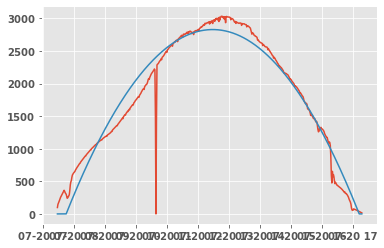

In [87]:
plt.plot(data_site.index, data_site['power'])
plt.plot(data_site.index, data_site['power_expected'])
plt.show()

In [89]:
best_percentage = 0 #initiation
for Vlimit in list(range (235, 256)):
    #step 1. Make a power limit value based on VW curve
    data_site['power_limit_vw'] = data_site['voltage'].apply(voltWattCurve, limit = Vlimit) * ac_cap

    #step 2. Filter voltage and power, which is curtailed (expected power from polyfit is higher than allowed voltage)
    suspect_data_filter = data_site['power_limit_vw'] < data_site['power_expected'] 
    suspect_data = pd.DataFrame()
    suspect_data = data_site[suspect_data_filter].copy()

    #step 3. Count the percentage of datapoints from previous step in the buffer range of VWatt curve

    #create the buffer range
    BUFFER_HIGH_VAL =  150 #This is from Tim's thesis. In Tim's program the used value is 0.035 * ac_cap but IDK it doesn't work well.
    BUFFER_LOW_VAL = 150  #This is from Tim's thesis. In Tim's program the used value is 0.08 * ac_cap but IDK it doesn't work well.
    buffer_high_filter = suspect_data['power_relative'] > 0.9
    buffer_low_filter = ~buffer_high_filter

    pd.options.mode.chained_assignment = None  # default='warn'
    suspect_data.loc[buffer_high_filter, 'power_limit_upper'] = suspect_data['power_limit_vw'] + BUFFER_HIGH_VAL
    suspect_data.loc[buffer_high_filter, 'power_limit_lower'] = suspect_data['power_limit_vw'] - BUFFER_HIGH_VAL

    suspect_data.loc[buffer_low_filter, 'power_limit_upper'] = suspect_data['power_limit_vw'] + BUFFER_LOW_VAL
    suspect_data.loc[buffer_low_filter, 'power_limit_lower'] = suspect_data['power_limit_vw'] - BUFFER_LOW_VAL

    #count points in buffer
    is_low_ok = suspect_data['power_limit_lower'] < suspect_data['power']
    is_upp_ok = suspect_data['power'] < suspect_data['power_limit_upper']
    suspect_data['is_in_buffer_range'] = is_low_ok & is_upp_ok
    count_in_buffer_range = suspect_data['is_in_buffer_range'].values.sum() #count true in a col
    percentage_in_buffer_range = count_in_buffer_range / len(suspect_data.index) * 100

    #put the best VWLimit stats
    if percentage_in_buffer_range > best_percentage or best_percentage == 0:
        best_percentage = percentage_in_buffer_range
        best_Vlimit = Vlimit

#step 4. If the percentage from the previous step is higher than certain limit, we say it shows VWatt response.
PERCENTAGE_THRESHOLD = 84
print(best_percentage)
print (best_Vlimit)
if best_percentage > PERCENTAGE_THRESHOLD: #Tim uses count threshold and gradient threshold. I am not sure whether it is necessary.
    vwatt_response = 'Yes'
    vwatt_curt_energy = check_energy_curtailed(suspect_data)
elif suspect_data['voltage'].max() < 255:
    vwatt_response = 'Inconclusive due to insufficient data points'
    vwatt_curt_energy = float('nan')
else: #no Vlimit results a good fit in all possible Vlimit value
    vwatt_response = 'None'
    vwatt_curt_energy = 0

40.0
242


C:\Users\samha\AppData\Local\Temp\ipykernel_14960\2969213268.py:31: RuntimeWarning: invalid value encountered in long_scalars
  percentage_in_buffer_range = count_in_buffer_range / len(suspect_data.index) * 100
C:\Users\samha\AppData\Local\Temp\ipykernel_14960\2969213268.py:31: RuntimeWarning: invalid value encountered in long_scalars
  percentage_in_buffer_range = count_in_buffer_range / len(suspect_data.index) * 100
C:\Users\samha\AppData\Local\Temp\ipykernel_14960\2969213268.py:31: RuntimeWarning: invalid value encountered in long_scalars
  percentage_in_buffer_range = count_in_buffer_range / len(suspect_data.index) * 100
C:\Users\samha\AppData\Local\Temp\ipykernel_14960\2969213268.py:31: RuntimeWarning: invalid value encountered in long_scalars
  percentage_in_buffer_range = count_in_buffer_range / len(suspect_data.index) * 100
C:\Users\samha\AppData\Local\Temp\ipykernel_14960\2969213268.py:31: RuntimeWarning: invalid value encountered in long_scalars
  percentage_in_buffer_range =

In [102]:
best_percentage = 0 #initiation
Vlimit = 242

#step 1. Make a power limit value based on VW curve
data_site['power_limit_vw'] = data_site['voltage'].apply(voltWattCurve, limit = Vlimit) * ac_cap

#step 2. Filter voltage and power, which is curtailed (expected power from polyfit is higher than allowed voltage)
suspect_data_filter = data_site['power_limit_vw'] < data_site['power_expected'] 
suspect_data = pd.DataFrame()
suspect_data = data_site[suspect_data_filter].copy()

#step 3. Count the percentage of datapoints from previous step in the buffer range of VWatt curve

#create the buffer range
BUFFER_HIGH_VAL =  150 #This is from Tim's thesis. In Tim's program the used value is 0.035 * ac_cap but IDK it doesn't work well.
BUFFER_LOW_VAL = 150  #This is from Tim's thesis. In Tim's program the used value is 0.08 * ac_cap but IDK it doesn't work well.
buffer_high_filter = suspect_data['power_relative'] > 0.9
buffer_low_filter = ~buffer_high_filter

pd.options.mode.chained_assignment = None  # default='warn'
suspect_data.loc[buffer_high_filter, 'power_limit_upper'] = suspect_data['power_limit_vw'] + BUFFER_HIGH_VAL
suspect_data.loc[buffer_high_filter, 'power_limit_lower'] = suspect_data['power_limit_vw'] - BUFFER_HIGH_VAL

suspect_data.loc[buffer_low_filter, 'power_limit_upper'] = suspect_data['power_limit_vw'] + BUFFER_LOW_VAL
suspect_data.loc[buffer_low_filter, 'power_limit_lower'] = suspect_data['power_limit_vw'] - BUFFER_LOW_VAL

#count points in buffer
is_low_ok = suspect_data['power_limit_lower'] < suspect_data['power']
is_upp_ok = suspect_data['power'] < suspect_data['power_limit_upper']
suspect_data['is_in_buffer_range'] = is_low_ok & is_upp_ok
count_in_buffer_range = suspect_data['is_in_buffer_range'].values.sum() #count true in a col
percentage_in_buffer_range = count_in_buffer_range / len(suspect_data.index) * 100

#put the best VWLimit stats
if percentage_in_buffer_range > best_percentage or best_percentage == 0:
    best_percentage = percentage_in_buffer_range
    best_Vlimit = Vlimit

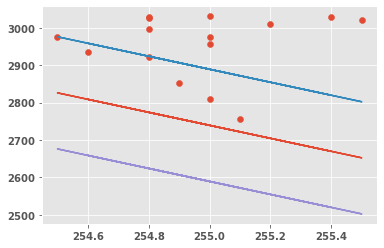

In [105]:
plt.scatter(suspect_data['voltage'], suspect_data['power'])
plt.plot(suspect_data['voltage'], suspect_data['power_limit_vw'])
plt.plot(suspect_data['voltage'], suspect_data['power_limit_upper'])
plt.plot(suspect_data['voltage'], suspect_data['power_limit_lower'])
plt.show()

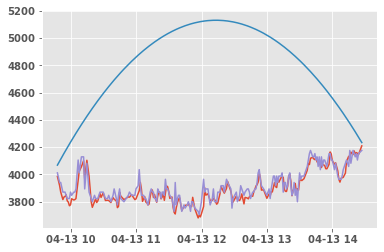

In [126]:
plt.plot(suspect_data.index, suspect_data['power'])
plt.plot(suspect_data.index, suspect_data['power_expected'])
plt.plot(suspect_data.index, suspect_data['power_limit_vw'])
plt.show()

# POLYFIT BUG FOR SAMPLE 3

In [ ]:
sample_filename = '/data_sample_3.csv'

data = pd.read_csv(file_path + sample_filename)
pd.to_datetime(data['Timestamp'].str.slice(0, 19, 1))
data['Timestamp'] = pd.to_datetime(data['Timestamp'].str.slice(0, 19, 1))
data.set_index('Timestamp', inplace=True)

c_id = data['c_id'][0]
date = str(data.index[0])[:10]

In [245]:
data_site, ac_cap, dc_cap, eff_system, inverter = site_organize(c_id, site_details, data, unique_cids)
data_site['cf'] = data_site['power']/ac_cap

In [248]:
data_site.index.rename('ts', inplace = True)

In [249]:
sunrise, sunset, data_site = filter_sunrise_sunset(data_site)
data_site = data_site.loc[data_site['power'] > 300]

In [268]:
powerArray, timeArray = filter_power_data(data_site)

In [259]:
timeArray = timeArray.strftime('%Y-%m-%d %H:%M:%S')
timeArray = timeArray.to_series(index=None, name='None')
powerArray, timeArray = FilterDataLimitedGradients(powerArray, timeArray)

In [186]:
timeArrayFloat = getDateTimeList(timeArray)

In [199]:
polyfit = GetPolyfit(timeArrayFloat, powerArray, 2)

In [209]:
polyfitPowerArray = polyfit(timeArrayFloat)

In [280]:
timestamp = data_site.index
timestamp = timestamp.strftime('%Y-%m-%d %H:%M:%S')
timestamp = getDateTimeList(timestamp)
maxPowerArray = polyfit(timestamp)

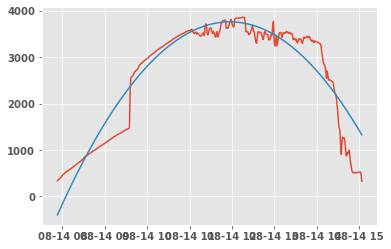

In [288]:
plt.plot(data_site.index, data_site['power'])
plt.plot(data_site.index, maxPowerArray)

In [291]:
error = abs(maxPowerArray - data_site['power'])

In [293]:
error[error<50].count()

37

This sucks. The polyfit doesn't work as expected. We should somehow modify the polyfit algorithm so that the expected power never falls below the real power.